# Quantum Satellite Placement

In [1]:
import itertools
import json
import math
import sys
import matplotlib.pyplot as plt
import dimod
import dynex
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Suppose you have a set of N satellites and k targets on Earth that you want to observe. Each of your satellites has varying capabilities for Earth observation; in particular, the amount of ground that they can observe for a set amount of time is different. Since there are k targets, you would like to have k constellations to monitor said targets. How do you group your satellites into k constellations such that the coverage of each constellation is maximized? This is what's being computed in the demo

## Helper functions

In [2]:
def calculate_score(constellation, data):
    """ Function to calculate constellation score."""

    score = 1
    for v in constellation:
        score *= (1 - data['coverage'][str(v)])
    score = 1 - score
    return score

In [3]:
def build_bqm(data, constellation_size):
    """ Build the bqm for the problem."""

    # don't consider constellations with average score less than score_threshold
    score_threshold = .4

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # first we want to favor combinations with a high score
    for constellation in itertools.combinations(range(data['num_satellites']), constellation_size):
        # the score is the probability of at least one satellite in the constelation having line of sight over the target at any one time.
        score = calculate_score(constellation, data)

        # to make it smaller, throw out the combinations with a score below
        # a set threshold
        if score < score_threshold:
            continue

        # we subtract the score because we want to minimize the energy
        bqm.add_variable(frozenset(constellation), -score)

    # next we want to penalize pairs that share a satellite. We choose 2 because
    # because we don't want it to be advantageous to pick both in the case that
    # they both have 100% coverage
    for c0, c1 in itertools.combinations(bqm.variables, 2):
        if c0.isdisjoint(c1):
            continue
        bqm.add_interaction(c0, c1, 2)

    # finally we wish to choose num_constellations variables. We pick strength of 1
    # because we don't want it to be advantageous to violate the constraint by
    # picking more variables
    bqm.update(dimod.generators.combinations(bqm.variables, data['num_constellations'], strength=1))

    return bqm

In [4]:
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

def viz(constellations, data):
    """ Visualize the solution"""
    
    angle = 2*math.pi / data["num_satellites"]
    plt.figure(figsize=(10,6))
    img = plt.imread("satellite-data/earth.jpg")
    
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:black')
    
    plt.title('Satellite Constellations\n'+str(data['num_satellites'])+' satellites, '+str(data['num_constellations'])+' targets', color='white')
    plt.imshow(img, zorder=0, extent=[-1.5, 1.5, -1, 1])
    
    s = 0
    for c in constellations:
        x = []
        y = []
        label = []
        for satellite in c:
            coverage = 1 - data["coverage"][str(satellite)]
            label.append(satellite)
            x.append(coverage*math.cos(s*angle))
            y.append(coverage*math.sin(s*angle)+0.3)
            s += 1
    
        x.append(x[0])
        y.append(y[0])
        label.append(label[0])
        plt.plot(x, y, zorder=1, marker = 'o', markersize=10, color='white')
    plt.tight_layout()
    plt.axis('off')
    plt.show()

## Quantum Solution

In [5]:
with open('satellite-data/small.json', 'r') as fp:
    data = json.load(fp)

In [6]:
print('Number of satellites:',data['num_satellites']);
print('Number of targets on earth to observe:',data['num_constellations']);

Number of satellites: 12
Number of targets on earth to observe: 4


In [7]:
# each of the x satellites (labelled 0..n-1) has a coverage score. This could be
# calculated as the percentage of time that the Earth region is in range of the
# satellite

constellation_size = data['num_satellites'] // data['num_constellations']

bqm = build_bqm(data, constellation_size)

In [8]:
sampleset = dynex.sample(bqm, mainnet=True, num_reads=10000, annealing_time=1000, description='Satellite Positioning', bnb=False);
print(sampleset)

╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │   ELAPSED │   WORKERS READ │   CIRCUITS │   STEPS │   GROUND STATE │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼────────────────┼────────────┼─────────┼────────────────┤
│       8397 │      228 │           24318 │        8.34 │      2.18 │              1 │       9984 │    1000 │    17324339.00 │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴────────────────┴────────────┴─────────┴────────────────╯
╭────────────┬─────────────────┬────────────┬───────┬─────────────┬───────────────┬─────────────────────────────┬──────────────┬──────────╮
│     WORKER │         VERSION │   CIRCUITS │   LOC │      ENERGY │       RUNTIME │                 LAST UPDATE │        STEPS │   STATUS │
├────────────┼─────────────────┼────────────┼───────┼─────────────┼───────────────┼──

Constellation: frozenset({0, 1, 2}), Score: 0.98656
Constellation: frozenset({11, 3, 6}), Score: 0.997228
Constellation: frozenset({8, 4, 7}), Score: 0.942976
Constellation: frozenset({9, 10, 5}), Score: 0.994525
Total Score: 3.9212890000000002
Normalized Score (tot / # constellations): 0.9803222500000001


<Figure size 1000x600 with 0 Axes>

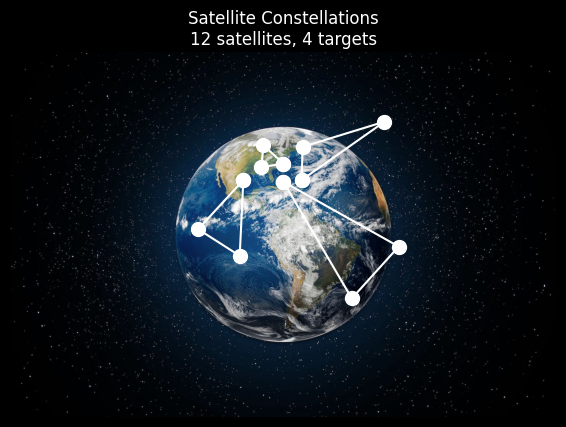

In [9]:
constellations = [constellation
                for constellation, chosen in sampleset.first.sample.items()
                if chosen]

tot = 0
for constellation in constellations:
    score = calculate_score(constellation, data)
    print("Constellation: " + str(constellation) + ", Score: " + str(score))
    tot += score
print("Total Score: " + str(tot))
print("Normalized Score (tot / # constellations): " + str((tot / data['num_constellations'])))

viz(constellations, data)